In [18]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
%matplotlib inline
import matplotlib.pyplot as plt
import weatherdataprocesstool as wt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from mpl_toolkits.mplot3d import Axes3D


# 資料處理

In [19]:
dataset_rmoutliers=pd.read_pickle('/Users/benbilly3/Desktop/資策會專題/rawMaterialPricePrediction/US_Weather/US_weather_cornsArea_traindata.pickle')
dataset_rmoutliers=dataset_rmoutliers.drop(columns='return')

In [20]:
X, y = dataset_rmoutliers.iloc[:, :-1].values, dataset_rmoutliers.iloc[:, -1].values

# #分割資料成4部分
# X_train, X_test, y_train, y_test = \
#     train_test_split(X, y, test_size=0.1, 
#                      stratify=y,
#                      random_state=1)

T='2008'
select = dataset_rmoutliers.index.get_level_values('date2') < T
X_train = X[select]
X_test= X[~select]
y_train = y[select]
y_test = y[~select]

# 標準化資料
sc = StandardScaler()#標準化物件
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

# 看PCA變化

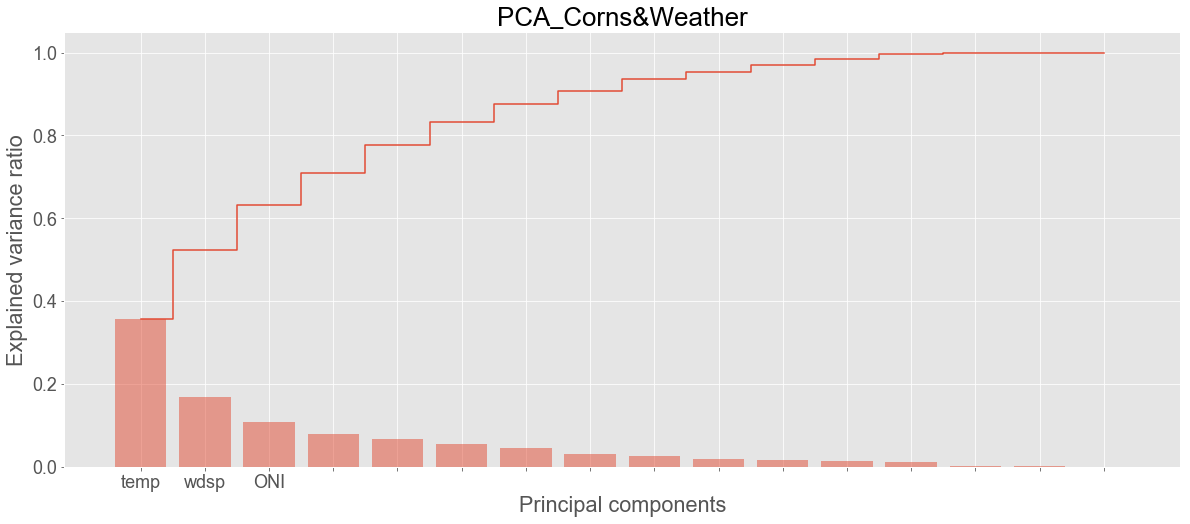

In [21]:
plt.rcParams["figure.figsize"] = (20,8)
plt.rcParams['font.family']=['Arial Unicode MS']
plt.rcParams['font.size']=18

pca_show = PCA()#n_components設為0，看所有屬性影響值
X_train_pca = pca_show .fit_transform(X_train_std)

#PCA_Feature 排行
# number of components
n_pcs= pca_show.components_.shape[0]
# # get the index of the most important feature on EACH component i.e. largest absolute value
# # using LIST COMPREHENSION HERE
most_important = [np.abs(pca_show.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names =dataset_rmoutliers.columns.tolist()
# # get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# pca_show .explained_variance_ratio:看所有屬性影響值
plt.bar(range(1, len(dataset_rmoutliers.columns)), pca_show.explained_variance_ratio_, alpha=0.5, align='center')
plt.xticks([i for i in range(1,len(dataset_rmoutliers.columns))],most_important_names[:3])
#階梯圖
plt.step(range(1, len(dataset_rmoutliers.columns)), np.cumsum(pca_show .explained_variance_ratio_), where='mid')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.title('PCA_Corns&Weather')
plt.style.use("ggplot")
plt.show()


# SVM Model

https://scikit-learn.org/stable/modules/svm.html

In [5]:
#降維
pca = PCA(n_components=5)#降到2維,n_components為控制維度變數
X_train_pca = pca.fit_transform(X_train_std)#標準化
X_test_pca = pca.transform(X_test_std)#標準化


Accuracy: 0.62


,跟上漲月率,錯過漲月率,跟上跌月率,躲過跌月率,精準度
SVM,44.59,55.41,26.15,73.85,59.22


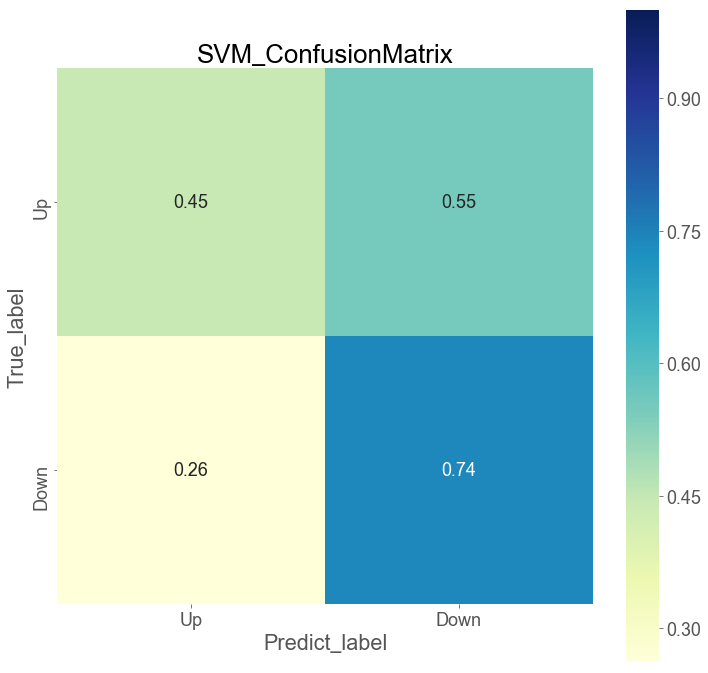

In [6]:
svm = SVC(C=1, class_weight=None, coef0=0.1,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

#C一般可以选择为：10^t , t=[- 4，4]就是0.0001 到10000。选择的越大，表示对错误例惩罚程度越大，可能会导致模型过拟合
svm.fit(X_train_pca, y_train)


y_pred= svm .predict(X_train_pca)# 顯示預測標籤
print('Accuracy: %.2f' % accuracy_score(y_train, y_pred))# 顯示預測準確度，y_test為實際結果，y_pred為預測值


y_pred_SVM= svm.predict(X_test_pca)# 顯示預測標籤
wt.confusionMatrixSheet(y_test,y_pred_SVM,'SVM')

In [7]:
# #2維繪圖
# wt.plot_decision_regions(X_train_pca, y_train, classifier=svm)
# plt.xlabel('PC 1')
# plt.ylabel('PC 2')
# plt.title('SVM_Train_Accuracy_Corns&Weather')
# plt.legend(loc='lower left')
# plt.tight_layout()
# # plt.savefig('images/05_04.png', dpi=300)
# plt.show()

##呈現test分佈圖
# wt.plot_decision_regions(X_test_pca, y_test, classifier=svm)
# plt.xlabel('PC 1')
# plt.ylabel('PC 2')
# plt.title('SVM_Test_Accuracy_Corns&Weather')
# plt.legend(loc='lower left')
# plt.tight_layout()
# # plt.savefig('images/05_05.png', dpi=300)
# plt.show()

# RF Model

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

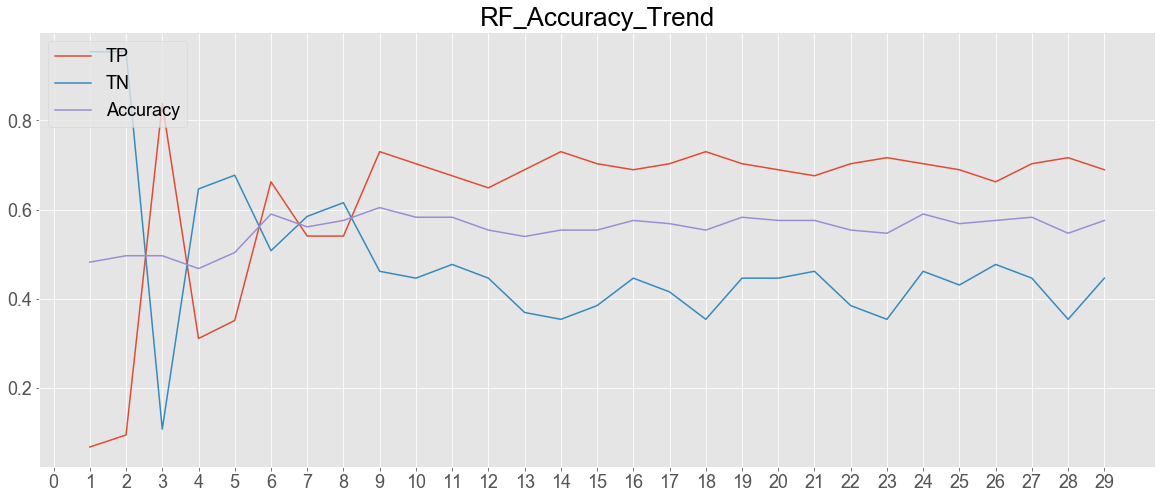

In [22]:
# #降維
pca = PCA(n_components=5)#降到2維,n_components為控制維度變數
X_train_pca = pca.fit_transform(X_train_std)#標準化
X_test_pca = pca.transform(X_test_std)#標準化


d=[]
d2=[]
d3=[]

s=1
e=30
k_range=range(s,e)
for k in k_range:
    #套入選取器
    tree = DecisionTreeClassifier(criterion='gini', max_depth=k,min_samples_split=2)
    tree .fit(X_train_pca, y_train)

    from sklearn.metrics import accuracy_score
    y_pred= tree.predict(X_train_pca)# 顯示預測標籤
    # print('Accuracy: %.2f' % accuracy_score(y_train, y_pred))# 顯示預測準確度，y_test為實際結果，y_pred為預測值

    from sklearn.metrics import accuracy_score
    y_pred_RF= tree.predict(X_test_pca)# 顯示預測標籤
#     print('Accuracy: %.2f' % accuracy_score(y_test, y_pred_RF))# 顯示預測準確度，y_test為實際結果，y_pred為預測值


    d.append(sum([1 if (a==1)&(b==1) else 0 for a,b in zip(y_test,y_pred_RF)])/(list(y_test).count(1)))
    d2.append(sum([1 if (a==0)&(b==0) else 0 for a,b in zip(y_test,y_pred_RF)])/(list(y_test).count(0)))
    d3.append(accuracy_score(y_test, y_pred_RF))
plt.rcParams["figure.figsize"] = (20,8)
plt.rcParams['font.family']=['Arial Unicode MS']
plt.rcParams['font.size']=18
plt.plot(k_range,d,label='TP')
plt.plot(k_range,d2,label='TN')
plt.plot(k_range,d3,label='Accuracy')
plt.xticks(range(len(k_range)+1),range(0,e))
plt.title('RF_Accuracy_Trend')
plt.legend(loc='upper left')

Accuracy: 0.77


,跟上漲月率,錯過漲月率,跟上跌月率,躲過跌月率,精準度
RF,52.7,47.3,38.46,61.54,57.12


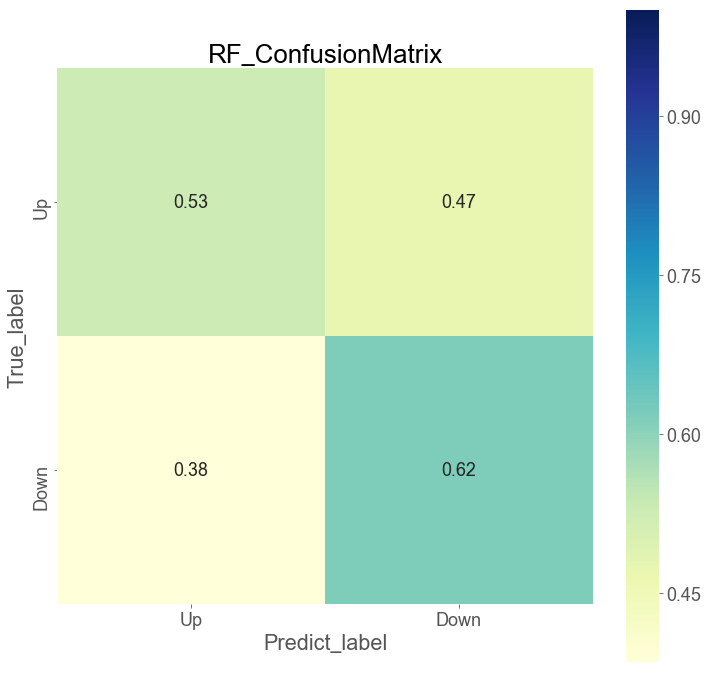

In [9]:
tree = DecisionTreeClassifier(criterion='gini', max_depth=8,min_samples_split=2)
tree .fit(X_train_pca, y_train)


y_pred= tree.predict(X_train_pca)# 顯示預測標籤
print('Accuracy: %.2f' % accuracy_score(y_train, y_pred))# 顯示預測準確度，y_test為實際結果，y_pred為預測值


y_pred_RF= tree.predict(X_test_pca)# 顯示預測標籤
wt.confusionMatrixSheet(y_test,y_pred_RF,'RF')

In [10]:
# #2維繪圖
# plt.rcParams["figure.figsize"] = (20,8)
# plt.rcParams['font.family']=['Arial Unicode MS']
# plt.rcParams['font.size']=18
# wt.plot_decision_regions(X_train_pca, y_train, classifier=tree )
# plt.xlabel('PC 1')
# plt.ylabel('PC 2')
# plt.title('RF_Train_Accuracy_Corns&Weather')
# plt.legend(loc='lower left')
# plt.tight_layout()
# # plt.savefig('images/05_04.png', dpi=300)
# plt.show()

# # 呈現test分佈圖
# wt.plot_decision_regions(X_test_pca, y_test, classifier=tree)
# plt.xlabel('PC 1')
# plt.ylabel('PC 2')
# plt.title('RF_Test_Accuracy_Corns&Weather')
# plt.legend(loc='lower left')
# plt.tight_layout()
# # plt.savefig('images/05_05.png', dpi=300)
# plt.show()


In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


param_test1= {"n_estimators":range(10,101,5)}  
gsearch1= GridSearchCV(estimator = RandomForestClassifier(),param_grid =param_test1)  
gsearch1.fit(X_train_pca, y_train)  
gsearch1.best_params_, gsearch1.best_score_  


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


({'n_estimators': 25}, 0.527336860670194)

# KNN Model

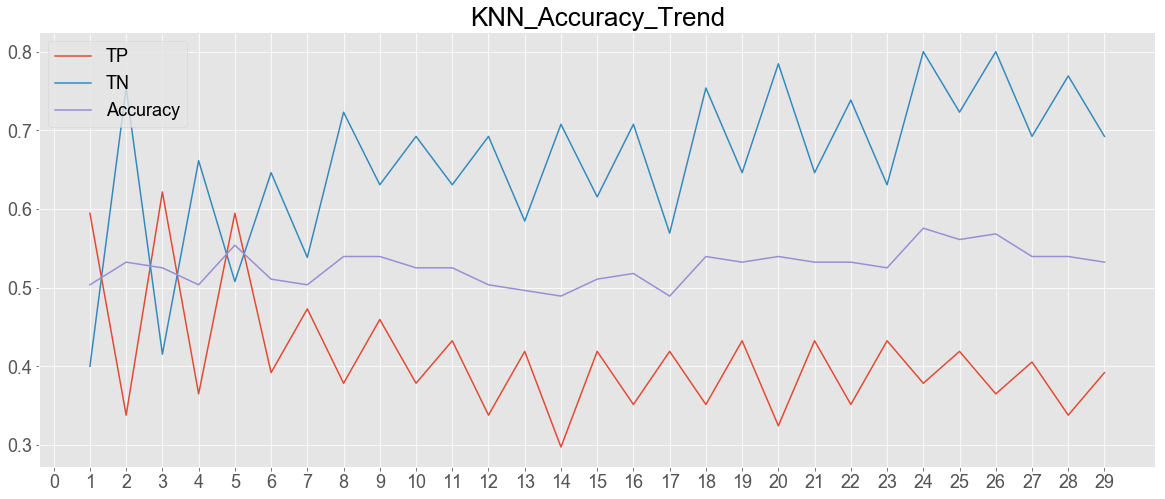

In [24]:
#降維
pca = PCA(n_components=5)#降到2維,n_components為控制維度變數
X_train_pca = pca.fit_transform(X_train_std)#標準化
X_test_pca = pca.transform(X_test_std)#標準化

d=[]
d2=[]
d3=[]
s=1
e=30
k_range=range(s,e)
for k in k_range:
    #套入選取器
    #套入選取器
    knn = KNeighborsClassifier(n_neighbors=k,p=2,metric='minkowski',algorithm='brute') #n_neighbors 選擇鄰居數
    knn.fit(X_train_pca, y_train)


    #模型精準度
    y_pred= knn.predict(X_train_pca)# 顯示預測標籤
#     print('Accuracy: %.2f' % accuracy_score(y_train, y_pred))# 顯示預測準確度，y_test為實際結果，y_pred為預測值
    y_pred_KNN= knn.predict(X_test_pca)# 顯示預測標籤


    d.append(sum([1 if (a==1)&(b==1) else 0 for a,b in zip(y_test,y_pred_KNN)])/(list(y_test).count(1)))
    d2.append(sum([1 if (a==0)&(b==0) else 0 for a,b in zip(y_test,y_pred_KNN)])/(list(y_test).count(0)))
    d3.append(accuracy_score(y_test, y_pred_KNN))
    
plt.rcParams["figure.figsize"] = (20,8)
plt.rcParams['font.family']=['Arial Unicode MS']
plt.rcParams['font.size']=18
plt.plot(k_range,d,label='TP')
plt.plot(k_range,d2,label='TN')
plt.plot(k_range,d3,label='Accuracy')
plt.xticks(range(len(k_range)+1),range(0,e))
plt.title('KNN_Accuracy_Trend')
plt.legend(loc='upper left')

Accuracy: 0.59


,跟上漲月率,錯過漲月率,跟上跌月率,躲過跌月率,精準度
KNN,37.84,62.16,18.46,81.54,59.69


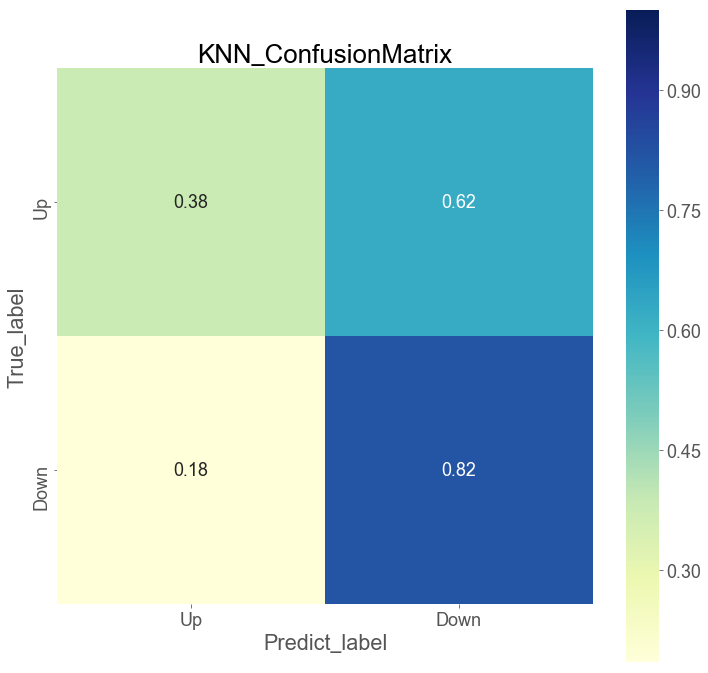

In [25]:
#套入選取器
knn = KNeighborsClassifier(n_neighbors=24,p=2,metric='minkowski') #n_neighbors 選擇鄰居數
knn.fit(X_train_pca, y_train)

#模型精準度
y_pred= knn.predict(X_train_pca)# 顯示預測標籤
print('Accuracy: %.2f' % accuracy_score(y_train, y_pred))# 顯示預測準確度，y_test為實際結果，y_pred為預測值

y_pred_KNN= knn.predict(X_test_pca)# 顯示預測標籤
wt.confusionMatrixSheet(y_test,y_pred_KNN,'KNN')

In [14]:
# # 呈現test分佈圖
# plt.rcParams["figure.figsize"] = (20,8)
# plt.rcParams['font.family']=['Arial Unicode MS']
# plt.rcParams['font.size']=30
# wt.plot_decision_regions(X_test_pca, y_test, classifier=knn)
# plt.xlabel('PC 1')
# plt.ylabel('PC 2')
# plt.title('KNN_Test_Accuracy_Corns&Weather')
# plt.legend(loc='lower left')
# plt.tight_layout()
# plt.savefig('images/05_05.png', dpi=300)
plt.show()

# #3D
# fig = plt.figure(1, figsize=(8, 6))
# ax = Axes3D(fig, elev=-150, azim=110)
# ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], X_test_pca[:, 2],c=y_test,cmap='RdYlBu')
# ax.set_title("First three PCA directions")
# ax.set_xlabel("1st eigenvector")
# ax.w_xaxis.set_ticklabels([])
# ax.set_ylabel("2nd eigenvector")
# ax.w_yaxis.set_ticklabels([])
# ax.set_zlabel("3rd eigenvector")
# ax.w_zaxis.set_ticklabels([])
# plt.show()

# #繪圖
# plt.rcParams["figure.figsize"] = (20,8)
# plt.rcParams['font.family']=['Arial Unicode MS']
# plt.rcParams['font.size']=18

# wt.plot_decision_regions(X_train_pca, y_train, classifier=knn )
# plt.xlabel('PC 1')
# plt.ylabel('PC 2')
# plt.title('RF_Train_Accuracy_Corns&Weather')
# plt.legend(loc='lower left')
# plt.tight_layout()
# # plt.savefig('images/05_04.png', dpi=300)
# plt.show()

# #3D
# fig = plt.figure(1, figsize=(12, 8))
# ax = Axes3D(fig, elev=-150, azim=110)
# ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], X_train_pca[:, 2],c=y_train,cmap=('RdYlBu'))
# ax.set_title("First three PCA directions")
# ax.set_xlabel("1st eigenvector")
# ax.w_xaxis.set_ticklabels([])
# ax.set_ylabel("2nd eigenvector")
# ax.w_yaxis.set_ticklabels([])
# ax.set_zlabel("3rd eigenvector")
# ax.w_zaxis.set_ticklabels([])
# plt.show()


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.py

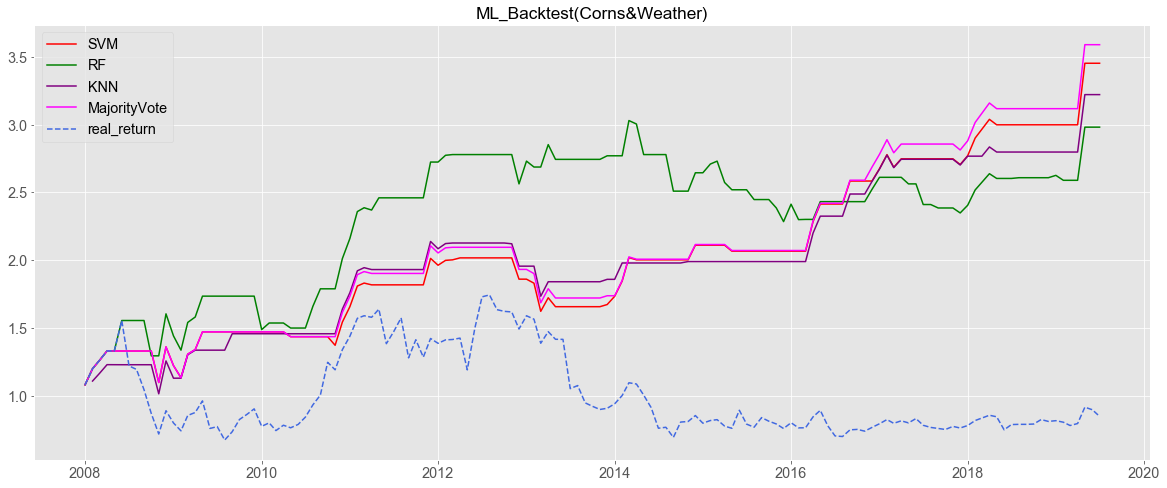

In [15]:
dataset_rmoutliers=pd.read_pickle('/Users/benbilly3/Desktop/資策會專題/rawMaterialPricePrediction/US_Weather/US_weather_cornsArea_traindata.pickle')
#回測年份
select = dataset_rmoutliers.index.get_level_values('date2') < T
df_bt=dataset_rmoutliers[~select]

#SVM
#帶入模型訊號
df_bt['model_single_SVM']=y_pred_SVM
df_bt_model=df_bt[df_bt['model_single_SVM']==1]
#模型回測報酬率計算
df_bt_model['model_backtest_SVM']=df_bt_model['return'].cumprod()
df_bt=pd.concat([df_bt,df_bt_model['model_backtest_SVM']],axis=1)
df_bt['model_backtest_SVM']=df_bt['model_backtest_SVM'].fillna(method='ffill')

#RF
#帶入模型訊號
df_bt['model_single_RF']=y_pred_RF
df_bt_model=df_bt[df_bt['model_single_RF']==1]
#模型回測報酬率計算
df_bt_model['model_backtest_RF']=df_bt_model['return'].cumprod()
df_bt=pd.concat([df_bt,df_bt_model['model_backtest_RF']],axis=1)
df_bt['model_backtest_RF']=df_bt['model_backtest_RF'].fillna(method='ffill')

#KNN
#帶入模型訊號
df_bt['model_single_KNN']=y_pred_KNN
df_bt_model=df_bt[df_bt['model_single_KNN']==1]
#模型回測報酬率計算
df_bt_model['model_backtest_KNN']=df_bt_model['return'].cumprod()
df_bt=pd.concat([df_bt,df_bt_model['model_backtest_KNN']],axis=1)
df_bt['model_backtest_KNN']=df_bt['model_backtest_KNN'].fillna(method='ffill')

#多數決
MajorityVoteClassifier=[1 if (i==2)or (i==3) else 0 for i in list(y_pred_SVM+y_pred_RF+y_pred_KNN)]
#帶入模型訊號
df_bt['model_single_MajorityVoteClassifier']=MajorityVoteClassifier
df_bt_model=df_bt[df_bt['model_single_MajorityVoteClassifier']==1]
#模型回測報酬率計算
df_bt_model['model_backtest_MajorityVoteClassifier']=df_bt_model['return'].cumprod()
df_bt=pd.concat([df_bt,df_bt_model['model_backtest_MajorityVoteClassifier']],axis=1)
df_bt['model_backtest_MajorityVoteClassifier']=df_bt['model_backtest_MajorityVoteClassifier'].fillna(method='ffill')

#無腦持有報酬率變化
df_bt['real_return']=df_bt['return'].cumprod()

plt.rcParams["figure.figsize"] = (20,8)
plt.rcParams['font.family']=['Arial Unicode MS']
plt.rcParams['font.size']=30

plt.style.use("ggplot")
plt.plot(df_bt['model_backtest_SVM'],color='red',label='SVM')
plt.plot(df_bt['model_backtest_RF'],color='green',label='RF')
plt.plot(df_bt['model_backtest_KNN'],color='purple',label='KNN')
plt.plot(df_bt['model_backtest_MajorityVoteClassifier'],color='fuchsia',label='MajorityVote')
plt.plot(df_bt['real_return'],'--',color='royalblue')
plt.title('ML_Backtest(Corns&Weather)',fontsize='xx-large')
plt.yticks(fontsize='x-large')
plt.xticks(fontsize='x-large')
plt.legend(fontsize='x-large')

In [16]:
# pd.concat([wt.confusionMatrixSheet(y_test,y_pred_SVM,'SVM'),
#           wt.confusionMatrixSheet(y_test,y_pred_RF,'RF'),
#           wt.confusionMatrixSheet(y_test,y_pred_KNN,'KNN')]
#          )